## Taxonomic Overlap Analysis

To evaluate the consistency and complementarity of different taxonomic annotation strategies in metaproteomics, we compare the taxa identified via three distinct approaches:

- **Metagenomics PSM**: Peptide-spectrum matches against a sample-specific database constructed from metagenomic sequencing data.
- **DIAMOND Proteome DB**: Matches obtained by aligning peptides against a clustered UniProt proteome set using DIAMOND.
- **Pept2LCA Genus DB**: A custom genus-level protein database derived from peptide-to-taxonomy mappings using the Pept2LCA pipeline.

This comparison is conducted at multiple taxonomic ranks (species, genus, family) to assess how each strategy performs across different levels of resolution.

We extract the lowest common ancestor (LCA) assignments from each dataset, normalize the taxon names for consistency, and apply hit thresholds to retain only confidently observed taxa. Venn diagrams are then used to visualize the taxonomic overlap between the datasets. This helps us identify shared core taxa, strategy-specific detections, and potential gaps in coverage, providing critical insights into the strengths and limitations of each annotation approach.



--- Species Level (min 100 hits) ---
Metagenomics PSM:  17 taxa → ['accumulibacter sp.', 'acidobacteriota bacterium', 'actinomycetales bacterium', 'anaerolineae bacterium', 'anaerolineales bacterium', 'bacteroidota bacterium', 'candidatus accumulibacter', 'candidatus competibacter', 'candidatus competibacteraceae', 'dechloromonas sp.', 'ideonella sp.', 'ignavibacteria bacterium', 'ignavibacteriales bacterium', 'nitrospira sp.', 'polyangiaceae bacterium', 'rhodocyclaceae bacterium', 'saprospiraceae bacterium']
DIAMOND DB:        10 taxa → ['accumulibacter regalis', 'candidatus accumulibacter', 'candidatus competibacteraceae', 'candidatus dechloromonas', 'candidatus phosphoribacter', 'candidatus propionivibrio', 'ignavibacteriales bacterium', 'nitrosomonas oligotropha', 'nitrospira defluvii', 'nitrospira sp.']
Pept2LCA Genus DB: 5 taxa → ['candidatus accumulibacter', 'candidatus dechloromonas', 'candidatus phosphoribacter', 'nitrosomonas oligotropha', 'nitrospira defluvii']

Shared by a

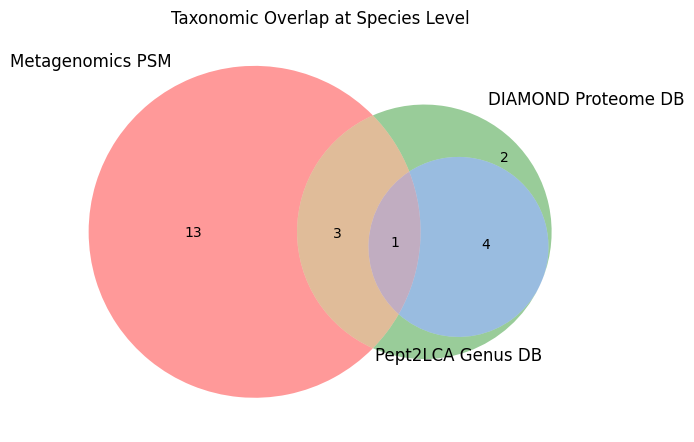


--- Genus Level (min 10 hits) ---
Metagenomics PSM:  14 taxa → ['acidovorax', 'afipia', 'allochromatium', 'candidatus accumulibacter', 'candidatus nitrotoga', 'dechloromonas', 'hyphomicrobium', 'nitrosomonas', 'nitrospira', 'propionivibrio', 'pseudomonas', 'pseudonocardia', 'skermanella', 'sphingopyxis']
DIAMOND DB:        2 taxa → ['candidatus accumulibacter', 'nitrosomonas']
Pept2LCA Genus DB: 5 taxa → ['candidatus accumulibacter', 'candidatus nitrotoga', 'dechloromonas', 'nitrosomonas', 'nitrospira']

Shared by all three (2): ['candidatus accumulibacter', 'nitrosomonas']
Metagenomics & DIAMOND only (0): []
Metagenomics & Pept2LCA only (3): ['candidatus nitrotoga', 'dechloromonas', 'nitrospira']
DIAMOND & Pept2LCA only (0): []


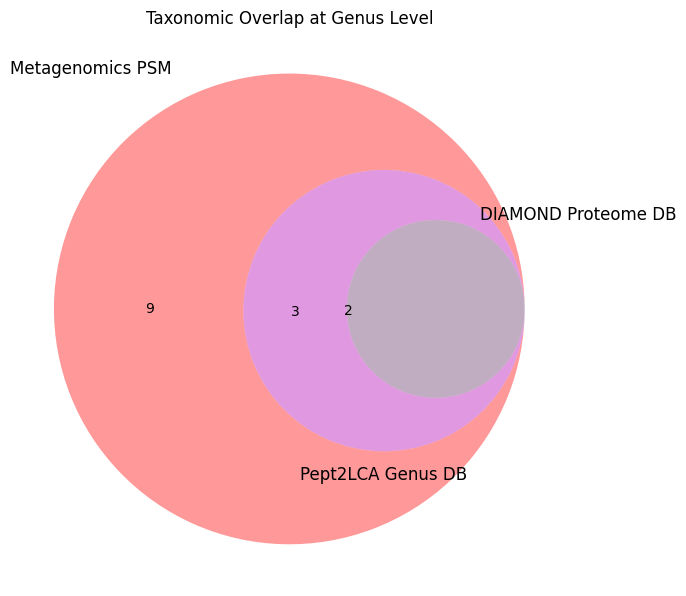


--- Family Level (min 10 hits) ---
Metagenomics PSM:  8 taxa → ['azonexaceae', 'beijerinckiaceae', 'caldilineaceae', 'candidatus competibacteraceae', 'chromatiaceae', 'comamonadaceae', 'paracoccaceae', 'rhizobiaceae']
DIAMOND DB:        1 taxa → ['candidatus competibacteraceae']
Pept2LCA Genus DB: 0 taxa → []

Shared by all three (0): []
Metagenomics & DIAMOND only (1): ['candidatus competibacteraceae']
Metagenomics & Pept2LCA only (0): []
DIAMOND & Pept2LCA only (0): []


C:\Users\Yusuf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib_venn\layout\venn3\pairwise.py:111: UserWarning: Circle C has zero area.
  warnings.warn("Circle C has zero area.")


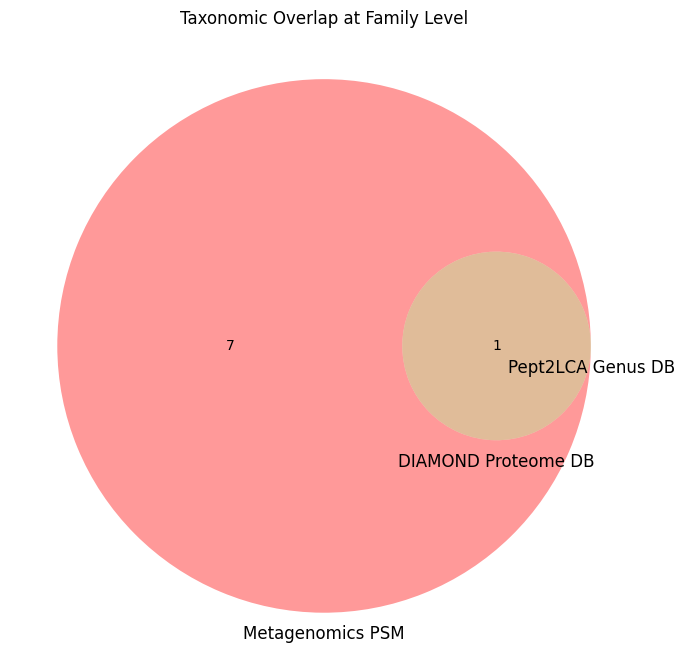

In [37]:
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
from collections import Counter

# === Load CSVs into DataFrames ===
df_meta = pd.read_csv("metagenomics_psm_taxa_annotated.csv")
df_diamond = pd.read_csv("diamond_from_proteomes_clust95_psm.csv")
df_genusdb = pd.read_csv("genus_composition_psm.csv")

# === Define frequency thresholds for filtering ===
thresholds = {
    "species": 100,
    "genus": 10,
    "family": 10
}

# === Taxon extractor with filtering and specific exception for 'candidatus competibacter' ===
def extract_normalized_taxa(df, rank_col, name_col, target_rank, min_count):
    df_filtered = df[df[rank_col] == target_rank]
    names = df_filtered[name_col].dropna().astype(str)
    normalized = names.str.lower().str.strip().apply(lambda x: " ".join(x.split()[:2]))

    counts = Counter(normalized)
    filtered = {taxon for taxon, count in counts.items() if count >= min_count}
    return filtered

# === Plot Venn Diagram and print all relevant taxa lists ===
def plot_taxa_overlap(rank):
    min_count = thresholds.get(rank, 1)

    meta_set = extract_normalized_taxa(df_meta, "taxon_rank", "taxon_name", rank, min_count)
    diamond_set = extract_normalized_taxa(df_diamond, "lca rank", "lca", rank, min_count)
    genusdb_set = extract_normalized_taxa(df_genusdb, "lca rank", "lca", rank, min_count)

    print(f"\n--- {rank.capitalize()} Level (min {min_count} hits) ---")
    print(f"Metagenomics PSM:  {len(meta_set)} taxa → {sorted(meta_set)}")
    print(f"DIAMOND DB:        {len(diamond_set)} taxa → {sorted(diamond_set)}")
    print(f"Pept2LCA Genus DB: {len(genusdb_set)} taxa → {sorted(genusdb_set)}")

    # Compute overlaps
    overlap_all = meta_set & diamond_set & genusdb_set
    overlap_meta_diamond = (meta_set & diamond_set) - overlap_all
    overlap_meta_genusdb = (meta_set & genusdb_set) - overlap_all
    overlap_diamond_genusdb = (diamond_set & genusdb_set) - overlap_all

    print(f"\nShared by all three ({len(overlap_all)}): {sorted(overlap_all)}")
    print(f"Metagenomics & DIAMOND only ({len(overlap_meta_diamond)}): {sorted(overlap_meta_diamond)}")
    print(f"Metagenomics & Pept2LCA only ({len(overlap_meta_genusdb)}): {sorted(overlap_meta_genusdb)}")
    print(f"DIAMOND & Pept2LCA only ({len(overlap_diamond_genusdb)}): {sorted(overlap_diamond_genusdb)}")

    # Plot Venn diagram
    plt.figure(figsize=(7, 7))
    venn3([meta_set, diamond_set, genusdb_set],
          set_labels=("Metagenomics PSM", "DIAMOND Proteome DB", "Pept2LCA Genus DB"))
    plt.title(f"Taxonomic Overlap at {rank.capitalize()} Level")
    plt.tight_layout()
    plt.show()

# === Run plots and print taxa lists for each rank ===
plot_taxa_overlap("species")
plot_taxa_overlap("genus")
plot_taxa_overlap("family")



## Taxonomic Overlap Across Database Strategies

To assess the agreement between different taxonomic annotation strategies, we compared the taxonomic profiles of PSMs derived from (i) a metagenomics-based reference database, (ii) a DIAMOND-based proteome search, and (iii) a genus-level custom Pept2LCA database. Taxa were extracted at the species, genus, and family levels, and filtered based on the number of supporting PSMs to ensure confident identifications. Minimum hit thresholds were set at **100 for species**, **10 for genus**, and **10 for family**.

### Species-Level Overlap (min 100 hits)

At the species level, the **metagenomics-based database** yielded the most diverse set with **17 taxa**, followed by **DIAMOND (10 taxa)** and **Pept2LCA (5 taxa)**. Only **one species**, *Candidatus Accumulibacter*, was shared across all three databases. An additional **3 species** were shared between metagenomics and DIAMOND only, including *Candidatus Competibacteraceae* and *Nitrospira sp.*. Notably, **4 species** were exclusively shared between DIAMOND and Pept2LCA, such as *Candidatus Dechloromonas* and *Nitrosomonas oligotropha*. The metagenomics approach recovered several taxa not observed in either of the other databases, likely reflecting its comprehensive coverage tailored to the sample’s microbial DNA.

### Genus-Level Overlap (min 10 hits)

At the genus level, **metagenomics again detected the broadest range** with **14 genera**, compared to **5 in Pept2LCA** and only **2 in DIAMOND**. Two genera—*Candidatus Accumulibacter* and *Nitrosomonas*—were common across all three strategies. Interestingly, **no genera were shared exclusively between metagenomics and DIAMOND**, while **3 were shared between metagenomics and Pept2LCA** (*Candidatus Nitrotoga*, *Dechloromonas*, *Nitrospira*). The limited overlap of DIAMOND at this rank may reflect both the more stringent filtering criteria and the absence of some genus-level annotations in the proteome-derived database.

### Family-Level Overlap (min 10 hits)

At the family level, **8 taxa were found via metagenomics**, with **1 overlapping family** (*Candidatus Competibacteraceae*) also identified via DIAMOND. Pept2LCA contributed no taxa above the 10-hit threshold at this level. The absence of Pept2LCA representation here highlights its limitation in resolving higher-rank taxonomy under the current confidence criteria. The one shared family suggests a consistent identification of this group by both high-coverage and fast-search strategies.

### Discussion

These results confirm that **metagenomics-derived taxonomic annotation** remains the most comprehensive strategy, particularly at lower taxonomic ranks where sequencing-based information captures rich community diversity. **DIAMOND**, while faster and broadly applicable, misses several taxa and is strongly biased toward well-represented proteins in existing databases. The **Pept2LCA genus DB**, although limited in scope, successfully recovers some genera and species identified by DIAMOND, and thus can complement other strategies when used with sufficient filtering.

Importantly, using LCA-based fields (rather than full taxon name matches) ensures **biologically meaningful comparisons** across strategies. 

Overall, **the combination of high PSM support thresholds and taxonomic normalization revealed that only a small core of taxa are robustly identified by all strategies**, emphasizing the importance of method-aware interpretation in metaproteomic profiling.
